# UNITE database Benchmark

This notebook tests the effects of different database versions on taxonomic information and classification accuracy, using the UNITE fungal ITS reference database.

In [1]:
import os
import qiime2 as q2
from qiime2.plugins import rescript, feature_table as ft, taxa as q2t
import pandas as pd
from glob import glob
import timeit
from rescript.cross_validate import _check_time
import tempfile
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('max_colwidth', 0)

%matplotlib inline

# Define inputs

Modify the filepaths here to your local filepaths to run this notebook.
The filepaths below merely point to the sequence and taxonomy files for the UNITE Feb 2020 release, clustered at different OTU % similarities and versions.

UNITE files can be downloaded and unzipped from here:

* https://plutof.ut.ee/#/datacite/10.15156/BIO/786385
* https://plutof.ut.ee/#/datacite/10.15156/BIO/786386

**DO NOT MODIFY ANY OTHER CELLS IN THIS NOTEBOOK IF YOU ARE ATTEMPTING TO REPLICATE THESE RESULTS**

In [2]:
# N jobs to use
n_jobs = 2
reads_per_batch = 5000

# location of reference database files
dbdir = '../../../ref_dbs/unite_02022019/'
alldir = '../../../ref_dbs/sh_qiime_release_s_all_04.02.2020/'
dbs = {
    'unite_{0}'.format(n): {
        'seqs': q2.Artifact.import_data(
            'FeatureData[Sequence]', dbdir + 'sh_refs_qiime_ver8_{0}_02.02.2019.fasta'.format(n)),
        'taxa': q2.Artifact.import_data(
            'FeatureData[Taxonomy]', dbdir + 'sh_taxonomy_qiime_ver8_{0}_02.02.2019.txt'.format(n),
            view_type='HeaderlessTSVTaxonomyFormat')}
    for n in ['97', '99', 'dynamic']}
dbs.update({
    'unite_2020_all_{0}'.format(n): {
        'seqs': q2.Artifact.import_data(
            'FeatureData[Sequence]', alldir + 'sh_refs_qiime_ver8_{0}_s_all_04.02.2020.fasta'.format(n)),
        'taxa': q2.Artifact.import_data(
            'FeatureData[Taxonomy]', alldir + 'sh_taxonomy_qiime_ver8_{0}_s_all_04.02.2020.txt'.format(n),
            view_type='HeaderlessTSVTaxonomyFormat')}
    for n in ['97', '99', 'dynamic']})

In [3]:
# drop singleton kingdoms
exclude = 'k__Bacteria,k__Chromista,k__Filasteriae,k__Nucleariae,k__Telonemae'
for n in ['97', '99', 'dynamic']:
    clean_taxa = dbs['unite_2020_all_' + n]['taxa'].view(pd.DataFrame)
    clean_taxa = clean_taxa[~clean_taxa.Taxon.str.contains(exclude.replace(',', '|'))]
    filtered_sequences, = q2t.actions.filter_seqs(
            sequences=dbs['unite_2020_all_' + n]['seqs'],
            taxonomy=dbs['unite_2020_all_' + n]['taxa'],
            exclude=exclude)
    dbs['unite_2020_all_{0}'.format(n)] = {
        'seqs': filtered_sequences,
        'taxa': q2.Artifact.import_data('FeatureData[Taxonomy]', clean_taxa)}
# fungi only
include = 'k__Fungi'
for n in ['97', '99', 'dynamic']:
    clean_taxa = dbs['unite_2020_all_' + n]['taxa'].view(pd.DataFrame)
    clean_taxa = clean_taxa[clean_taxa.Taxon.str.contains(include.replace(',', '|'))]
    filtered_sequences, = q2t.actions.filter_seqs(
            sequences=dbs['unite_2020_all_' + n]['seqs'],
            taxonomy=dbs['unite_2020_all_' + n]['taxa'],
            include=include)
    dbs['unite_2020_all_fungi_{0}'.format(n)] = {
        'seqs': filtered_sequences,
        'taxa': q2.Artifact.import_data('FeatureData[Taxonomy]', clean_taxa)}
# exclude anything not identified to order level
exclude = 'o__unidentified'
for n in ['97', '99', 'dynamic']:
    clean_taxa = dbs['unite_2020_all_fungi_' + n]['taxa'].view(pd.DataFrame)
    clean_taxa = clean_taxa[~clean_taxa.Taxon.str.contains(exclude)]
    filtered_sequences, = ft.actions.filter_seqs(
            data=dbs['unite_2020_all_fungi_' + n]['seqs'],
            metadata=q2.Metadata(clean_taxa))
    dbs['unite_2020_clean_{0}'.format(n)] = {
        'seqs': filtered_sequences,
        'taxa': q2.Artifact.import_data('FeatureData[Taxonomy]', clean_taxa)}


# Perform CV Classification
Both k-fold and "perfect classifiers" (no CV, leaky data, best possible performance)

In [39]:
# Cross-validation
times_cv = {}
for n, v in dbs.items():
    s, t = v['seqs'], v['taxa']
    print(n)
    exp_taxa_fp = '../data/expected/{0}_expected_taxonomy.qza'.format(n)
    if not os.path.exists(exp_taxa_fp):
        start = timeit.default_timer()
        exp, obs, = rescript.actions.evaluate_cross_validate(
            s, t, n_jobs=n_jobs, reads_per_batch=reads_per_batch)
        times_cv[n] = timeit.default_timer() - start
        exp.save(exp_taxa_fp)
        obs.save('../data/observed/{0}_observed_taxonomy.qza'.format(n))

unite_97
unite_99
unite_dynamic
unite_2020_all_97
unite_2020_all_99
unite_2020_all_dynamic
unite_2020_clean_97
unite_2020_clean_99
unite_2020_clean_dynamic
unite_2020_all_fungi_97
Validation: 4.32s


/Users/nbokulich/miniconda3/envs/qiime2-2020.5-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 split: 8.95s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 0 fit: 446.50s
Fold 0 classify: 1956.60s
Fold 1 split: 7.11s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 1 fit: 467.52s
Fold 1 classify: 2040.06s
Fold 2 split: 9.69s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 2 fit: 480.49s
Fold 2 classify: 2084.77s
Total Runtime: 7508.20s
unite_2020_all_fungi_99
Validation: 5.09s


/Users/nbokulich/miniconda3/envs/qiime2-2020.5-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 split: 11.01s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 0 fit: 635.98s
Fold 0 classify: 2551.36s
Fold 1 split: 9.04s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 1 fit: 631.54s
Fold 1 classify: 3025.34s
Fold 2 split: 8.47s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 2 fit: 675.10s
Fold 2 classify: 3443.25s
Total Runtime: 10997.70s
unite_2020_all_fungi_dynamic
Validation: 5.21s


/Users/nbokulich/miniconda3/envs/qiime2-2020.5-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 split: 10.62s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 0 fit: 661.51s
Fold 0 classify: 2452.64s
Fold 1 split: 7.81s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 1 fit: 617.31s
Fold 1 classify: 2434.79s
Fold 2 split: 7.89s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 2 fit: 628.64s
Fold 2 classify: 2287.79s
Total Runtime: 9115.46s


In [7]:
# "Perfect" classifier, no cross-validation
times_nocv = {}
for n, v in dbs.items():
    if n not in ['unite_2020_all_97', 'unite_2020_all_99', 'unite_2020_all_dynamic']:
        s, t = v['seqs'], v['taxa']
        print(n)
        classifier_fp = '../data/classifiers/{0}_nb_classifier.qza'.format(n)
        obs_taxa_fp = '../data/observed/{0}_observed_taxonomy_noCV.qza'.format(n)
        exp_taxa_fp = '../data/expected/{0}_expected_taxonomy_noCV.qza'.format(n)
        if not os.path.exists(exp_taxa_fp):
            start = timeit.default_timer()
            classifier, _, obs, = rescript.actions.evaluate_fit_classifier(
                s, t, n_jobs=n_jobs, reads_per_batch=reads_per_batch)
            times_nocv[n] = timeit.default_timer() - start
            classifier.save(classifier_fp)
            obs.save(obs_taxa_fp)
            t.save(exp_taxa_fp)


unite_97
unite_99
unite_dynamic
unite_2020_all_fungi_97
Validation: 4.61s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 895.76s
Classification: 8505.33s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 2.58s
Total Runtime: 9408.29s
unite_2020_all_fungi_99
Validation: 5.24s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 1164.91s
Classification: 12059.92s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 3.18s
Total Runtime: 13233.25s
unite_2020_all_fungi_dynamic
Validation: 5.25s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 1233.00s
Classification: 12119.73s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 2.94s
Total Runtime: 13360.91s
unite_2020_clean_97
Validation: 3.93s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 752.74s
Classification: 7538.14s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 2.60s
Total Runtime: 8297.40s
unite_2020_clean_99
Validation: 5.13s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 1110.62s
Classification: 10919.53s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 3.18s
Total Runtime: 12038.47s
unite_2020_clean_dynamic
Validation: 4.74s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 1104.07s
Classification: 11523.38s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 2.98s
Total Runtime: 12635.18s


In [8]:
exp_taxonomies = {os.path.splitext(os.path.basename(fp))[0].replace('_expected_taxonomy', ''): 
                  q2.Artifact.load(fp) for fp in glob('../data/expected/unite_*')}
obs_taxonomies = {os.path.splitext(os.path.basename(fp))[0].replace('_observed_taxonomy', ''): 
                  q2.Artifact.load(fp) for fp in glob('../data/observed/unite_*')}


# Evaluate Classification Accuracy

In [9]:
class_eval, = rescript.actions.evaluate_classifications(
    expected_taxonomies = [exp_taxonomies[i] for i in sorted(exp_taxonomies.keys())],
    observed_taxonomies = [obs_taxonomies[i] for i in sorted(obs_taxonomies.keys())],
    labels = sorted(obs_taxonomies.keys()))
class_eval.save('../data/eval/unite_fungi_classification_eval.qzv')

'../data/eval/unite_fungi_classification_eval.qzv'

# Evaluate Taxonomic Information

In [4]:
tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = [dbs[i]['taxa'] for i in sorted(dbs.keys())],
    labels = sorted(dbs.keys()))
tax_eval.save('../data/eval/unite_fungi_taxonomic_eval.qzv')
tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = [dbs[i]['taxa'] for i in sorted(dbs.keys())],
    labels = sorted(dbs.keys()),
    rank_handle_regex="^[dkpcofgs]__unidentified")
tax_eval.save('../data/eval/unite_fungi_taxonomic_eval_dropemptyranks.qzv')

'../data/eval/unite_fungi_taxonomic_eval_dropemptyranks.qzv'

# Evaluate Sequence Information

In [10]:
relabels = {
    'unite_2020_all_97': 'All Euks 97%',
    'unite_2020_all_97_noCV': 'All Euks 97% No CV',
    'unite_2020_all_99': 'All Euks 99%',
    'unite_2020_all_dynamic': 'All Euks Dynamic',
    'unite_2020_all_fungi_97': 'Fungi 97%',
    'unite_2020_all_fungi_97_noCV': 'Fungi 97% No CV',
    'unite_2020_all_fungi_99': 'Fungi 99%',
    'unite_2020_all_fungi_99_noCV': 'Fungi 99% No CV',
    'unite_2020_all_fungi_dynamic': 'Fungi Dynamic',
    'unite_2020_all_fungi_dynamic_noCV': 'Fungi Dynamic No CV',
    'unite_2020_clean_97': 'Fungi Order 97%',
    'unite_2020_clean_97_noCV': 'Fungi Order 97% No CV',
    'unite_2020_clean_99': 'Fungi Order 99%',
    'unite_2020_clean_99_noCV': 'Fungi Order 99% No CV',
    'unite_2020_clean_dynamic': 'Fungi Order Dynamic',
    'unite_2020_clean_dynamic_noCV': 'Fungi Order Dynamic No CV',
    'unite_97': 'drop',
    'unite_97_noCV': 'drop',
    'unite_99': 'drop',
    'unite_99_noCV': 'drop',
    'unite_dynamic': 'drop',
    'unite_dynamic_noCV': 'drop'}
cv_labels = [i for i in relabels.values() if 'CV' not in i and i != 'drop']
nocv_labels = [i for i in relabels.values() if 'CV' in i]


In [14]:
seqs_eval, = rescript.actions.evaluate_seqs(
    sequences = [dbs[i]['seqs'] for i in sorted(dbs.keys()) if relabels[i] != 'drop'],
    labels = [relabels[i] for i in sorted(dbs.keys()) if relabels[i] != 'drop'],
    palette = 'cividis')
seqs_eval.save('../data/eval/unite_fungi_seqs_eval.qzv')


'../data/eval/unite_fungi_seqs_eval.qzv'

# Make a pretty figure

The interactive figs are great, but we need to generate a static figure for publication :(

In [5]:
fig_data = dict()
with tempfile.TemporaryDirectory() as temp_dir_name:
    for f in glob('../data/eval/unite_*.qzv'):
        name = f.split('/')[-1].split('.qzv')[0]
        f = q2.Visualization.load(f)
        f.export_data(temp_dir_name)
        fig_data[name] = q2.Metadata.load(temp_dir_name + '/data.tsv').to_dataframe()


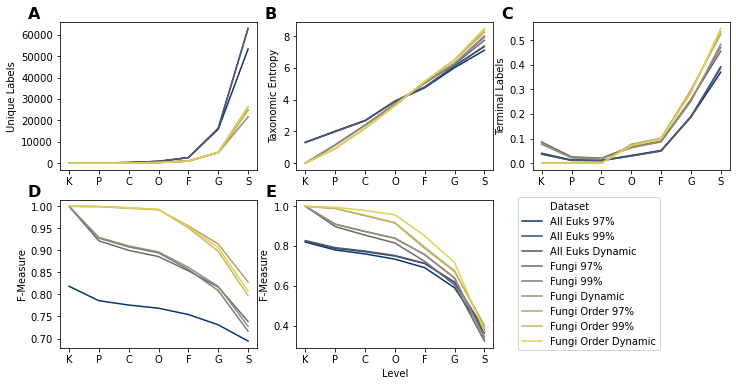

In [7]:
plot_keys = ['unite_fungi_taxonomic_eval',
             'unite_fungi_taxonomic_eval',
             'unite_fungi_taxonomic_eval_dropemptyranks',
             'unite_fungi_classification_eval',
             'unite_fungi_classification_eval']
signals = ['Unique Labels',
           'Taxonomic Entropy',
           'Proportion of Features Terminating at Depth',
           'F-Measure',
           'F-Measure']
labels = list('ABCDEF')

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=False)
axes = axes.flatten()
axes[-1].remove()
for ax, key, signal, label in zip(axes, plot_keys, signals, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    dat = fig_data[key].copy()
    dat.loc[:, 'Dataset'] = dat.loc[:, 'Dataset'].replace(relabels)
    dat = dat[dat['Dataset'] != 'drop']
    dat['Level'] = dat['Level'].replace({
        1: 'K', 2: 'P', 3: 'C', 4: 'O',
        5: 'F', 6: 'G', 7: 'S'})
    if ax == axes[3]:
        dat = dat[dat['Dataset'].isin(nocv_labels)]
        # create empty rows for consistent colors/label ordering
        # did not run All Euks 99% or dynamic with no CV
        # due to high runtime and similarity to 97% results in other tests
        dat.loc['998', 'Dataset'] = 'All Euks 99% No CV'
        dat.loc['999', 'Dataset'] = 'All Euks Dynamic No CV'
    if ax == axes[4]:
        dat = dat[dat['Dataset'].isin(cv_labels)]
        legend = 'brief'
    else:
        legend = False
    g = sns.lineplot(x='Level', y=signal, hue='Dataset', data=dat, ax=ax,
                     legend=legend, palette='cividis', sort=False,
                     hue_order=sorted(dat.Dataset.unique()))
    if ax == axes[2]:
        ax.set_ylabel('Terminal Labels')
    if ax == axes[4]:
        ax.legend(bbox_to_anchor=(1.1, 1.05))
    else:
        ax.set_xlabel('')
fig.savefig('../data/plots/unite_evaluation.pdf', bbox_inches='tight')


Fig XXX. Taxonomic information (A-C) and classification accuracy (D-E) of UNITE ITS domain database with different filtering and clustering settings. Filtered versions include the "all Eukaryotes" 2020.04.02 release version containing all Eukaryotes ("All Euks"), filtered to contain only Fungi, and filtered to contain only Fungi with at least order-level taxonomic annotation ("Fungi Order"). Cluster levels indicate which UNITE release version was used: sequences clustered at 97% similarity, 99% similarity, or the UNITE "dynamic" species hypothesis threshold. Subpanels show taxonomic/classification characteristics at each taxonomic level: A, Number of unique taxonomic labels; B, Taxonomic entropy; C, proportion of taxa that terminate at that level; D, optimal classification accuracy (as F-Measure) without cross-validation (simulating best possible classification accuracy when the true label is known but classification accuracy may be confounded by other similar hits in the database); E, classification accuracy (F-Measure) with cross-validation (simulating realistic classification tasks when the correct label is unknown). Level labels on x-axis: K = Kingdom, P = phylum, C = class, O = order, F = family, G = genus, S = species. See Materials and Methods for more details on how these databases were created and processed. From among the three "All Euks" databases tested, only the 97% OTUs were classified without cross-validation (panel D) due to the 